In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
plt.style.use('fivethirtyeight')

In [8]:
files = os.listdir('../Presentation/')
model_names = ['_'.join(filename.split('.md')[0].split()) for filename in files if filename.endswith('.md')]
plt.rcParams['figure.figsize'] = [16, 9]

In [11]:
def plot_training_progress(model_name):
    # read in parsed log data
    loss_progress = pd.read_csv('../Presentation/loss_progress_{}.csv'.format(model_name))
    lr_decay = pd.read_csv('../Presentation/lr_decay_{}.csv'.format(model_name))
    fitting_times = pd.read_csv('../Presentation/fitting_times_{}.csv'.format(model_name))
    # convert fitting times to minutes
    fitting_times['fitting_time'] = fitting_times['fitting_time'].\
        map(lambda x: pd.Timedelta(x).total_seconds() / 60)
    fig = plt.figure()
    plt.rcParams['figure.figsize'] = [16, 9]
    plt.rcParams['legend.fontsize'] = 20
    mean_loss, mean_acc = loss_progress.groupby('fold').agg({
        'valid_loss': lambda x: x.mean(),
        'valid_acc': lambda x: x.mean()
    }, axis=0).mean()    
    std_loss, std_acc = loss_progress.groupby('fold').agg({
        'valid_loss': lambda x: x.std(),
        'valid_acc': lambda x: x.std()
    }, axis=0).mean()
    plt.suptitle(model_name.replace('arm', '').replace('_', ' ').replace('ddnn', 'fc') + \
                 '   ({0:.2f} ± {1:.2f} minutes)'.format(
                     fitting_times['fitting_time'].mean(),
                     fitting_times['fitting_time'].std(),
                 ) + '\n' + \
                 ' Logloss: {0:.2f} ± {1:.2f}  -- Accuracy:  {2:.2f} ± {3:.2f}'.format(
                 mean_loss, std_loss, mean_acc, std_acc
                 )
                 , fontsize=18, linespacing=1.2)
    ax1 = plt.subplot(211)
    plt.title('Loss by epochs')
    ax2 = plt.subplot(212)
    plt.title('Accuracy by epochs')
    terminate_loss_loc, terminate_acc_loc = loss_progress.groupby('fold').agg({
            'valid_loss': lambda x: x.values.argmin(),
            'valid_acc': lambda x: x.values.argmax()
        }, axis=0).mean()

    for fold_num in range(1,6):
        fold_data = loss_progress.loc[loss_progress['fold'] == fold_num]
        ax1.plot(fold_data.epoch, fold_data.train_loss, color='b', alpha=0.3)
        ax1.plot(fold_data.epoch, fold_data.valid_loss, color='r', alpha=0.3)
        ax2.plot(fold_data.epoch, fold_data.train_acc, color='b', alpha=0.3)
        ax2.plot(fold_data.epoch, fold_data.valid_acc, color='r', alpha=0.3)
        for lr_decay_loc in lr_decay.loc[lr_decay.fold == fold_num].epoch:
            ax1.axvline(x=lr_decay_loc, color='m', alpha=0.1, linestyle=':')
            ax2.axvline(x=lr_decay_loc, color='m', alpha=0.1, linestyle=':')
        if fold_num == 1:
            ax1.legend(loc='upper right', ncol=2, frameon=True)
            ax2.legend(loc='lower right', ncol=2, frameon=True)
    for lr_decay_loc in lr_decay.groupby(['lr']).mean().epoch.values:
        ax1.axvline(x=lr_decay_loc, color='m', alpha=0.8, linestyle='-')
        ax2.axvline(x=lr_decay_loc, color='m', alpha=0.8, linestyle='-')
    
    ax1.axvline(x=terminate_loss_loc, color='y', alpha=0.8, linestyle='-')
    ax2.axvline(x=terminate_acc_loc, color='y', alpha=0.8, linestyle='-')
    plt.show()
    plt.savefig('../Presentation/plot_training_progress_{}.png'.format(model_name))
    plt.close('all')

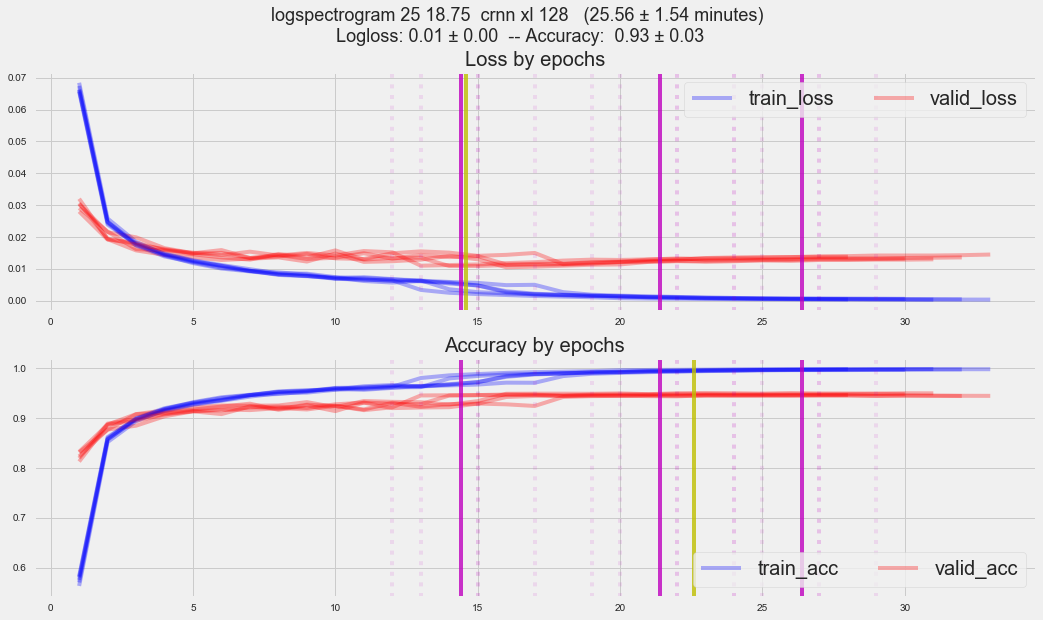

In [12]:
plot_training_progress('logspectrogram_25_18.75_arm_crnn_xl_128')